# • Probabilistic Forecast Evaluation

> Hierarchical Forecast's reconciliation and evaluation.

This notebook offers a step to step guide to create a hierarchical forecasting pipeline.

In the pipeline we will use `HierarchicalForecast` and `StatsForecast` core class, to create base predictions, reconcile and evaluate them. 

We will use the TourismL dataset that summarizes large Australian national visitor survey.

Outline
1. Installing Packages
2. Prepare TourismL dataset
    - Read and aggregate
    - StatsForecast's Base Predictions
3. Reconciliar
4. Evaluar

<a href="https://colab.research.google.com/github/Nixtla/hierarchicalforecast/blob/main/nbs/examples/TourismLarge-Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Installing HierarchicalForecast

We assume you have StatsForecast and HierarchicalForecast already installed, if not 
check this guide for instructions on how to install HierarchicalForecast.

In [ ]:
# %%capture
# !pip install hierarchicalforecast
# !pip install -U numba statsforecast datasetsforecast

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsforecast.core import StatsForecast
from statsforecast.models import AutoARIMA, Naive

from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.evaluation import HierarchicalEvaluation
from hierarchicalforecast.methods import BottomUp, TopDown, MinTrace, ERM

from hierarchicalforecast.utils import is_strictly_hierarchical
from hierarchicalforecast.utils import HierarchicalPlot, CodeTimer
from hierarchicalforecast.evaluation import scaled_crps, msse, energy_score

from datasetsforecast.hierarchical import HierarchicalData, HierarchicalInfo

## 2. Preparing TourismL Dataset

### 2.1 Read Hierarchical Dataset

In [ ]:
# ['Labour', 'Traffic', 'TourismSmall', 'TourismLarge', 'Wiki2']
dataset = 'TourismSmall' # 'TourismLarge'
verbose = True
intervals_method = 'bootstrap'
LEVEL = np.arange(0, 100, 2)
qs = [[50-lv/2, 50+lv/2] for lv in LEVEL]
QUANTILES = np.sort(np.concatenate(qs)/100)

In [ ]:
with CodeTimer('Read and Parse data   ', verbose):
    print(f'{dataset}')
    if not os.path.exists('./data'):
        os.makedirs('./data')
    
    dataset_info = HierarchicalInfo[dataset]
    Y_df, S_df, tags = HierarchicalData.load(directory=f'./data/{dataset}', group=dataset)
    Y_df['ds'] = pd.to_datetime(Y_df['ds'])

    # Train/Test Splits
    horizon = dataset_info.horizon
    seasonality = dataset_info.seasonality
    Y_test_df = Y_df.groupby('unique_id').tail(horizon)
    Y_train_df = Y_df.drop(Y_test_df.index)
    Y_test_df = Y_test_df.set_index('unique_id')
    Y_train_df = Y_train_df.set_index('unique_id')

TourismSmall
Code block 'Read and Parse data   ' took:	0.00966 seconds


In [ ]:
dataset_info.seasonality

4

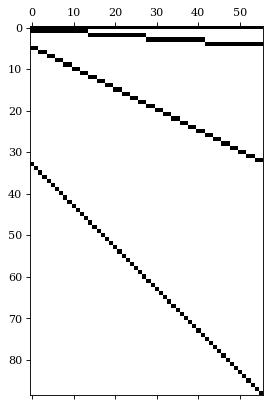

In [ ]:
hplot = HierarchicalPlot(S=S_df, tags=tags)
hplot.plot_summing_matrix()

In [ ]:
Y_train_df

,ds,y
unique_id,,
total,1998-03-31,84503
total,1998-06-30,65312
total,1998-09-30,72753
total,1998-12-31,70880
total,1999-03-31,86893
...,...,...
nt-oth-noncity,2003-12-31,132
nt-oth-noncity,2004-03-31,12
nt-oth-noncity,2004-06-30,40


### 2.2 StatsForecast's Base Predictions

This cell computes the base predictions `Y_hat_df` for all the series in `Y_df` using StatsForecast's `AutoARIMA`.
Additionally we obtain insample predictions `Y_fitted_df` for the methods that require them.

In [ ]:
%%capture
with CodeTimer('Fit/Predict Model     ', verbose):
    # Read to avoid unnecesary AutoARIMA computation
    yhat_file = f'./data/{dataset}/Y_hat.csv'
    yfitted_file = f'./data/{dataset}/Y_fitted.csv'

    if os.path.exists(yhat_file):
        Y_hat_df = pd.read_csv(yhat_file)
        Y_fitted_df = pd.read_csv(yfitted_file)

        Y_hat_df = Y_hat_df.set_index('unique_id')
        Y_fitted_df = Y_fitted_df.set_index('unique_id')

    else:
        fcst = StatsForecast(
            df=Y_train_df, 
            models=[AutoARIMA(season_length=seasonality)],
            fallback_model=[Naive()],
            freq='M', 
            n_jobs=-1
        )
        Y_hat_df = fcst.forecast(h=horizon, fitted=True, level=LEVEL)
        Y_fitted_df = fcst.forecast_fitted_values()
        Y_hat_df.to_csv(yhat_file)
        Y_fitted_df.to_csv(yfitted_file)

In [ ]:
Y_hat_df

,ds,AutoARIMA,AutoARIMA-lo-98,AutoARIMA-lo-96,AutoARIMA-lo-94,AutoARIMA-lo-92,AutoARIMA-lo-90,AutoARIMA-lo-88,AutoARIMA-lo-86,AutoARIMA-lo-84,...,AutoARIMA-hi-80,AutoARIMA-hi-82,AutoARIMA-hi-84,AutoARIMA-hi-86,AutoARIMA-hi-88,AutoARIMA-hi-90,AutoARIMA-hi-92,AutoARIMA-hi-94,AutoARIMA-hi-96,AutoARIMA-hi-98
unique_id,,,,,,,,,,,,,,,,,,,,,
bus,2005-01-31,9673.42500,7436.35640,7698.49370,7864.81150,7989.92600,8091.69630,8178.31930,8254.27050,8322.27600,...,10905.7940,10962.7260,11024.5730,11092.5790,11168.5300,11255.1530,11356.9240,11482.0380,11648.3560,11910.4930
bus,2005-02-28,10393.90000,8156.83150,8418.96900,8585.28700,8710.40100,8812.17200,8898.79500,8974.74600,9042.75200,...,11626.2700,11683.2000,11745.0490,11813.0550,11889.0060,11975.6290,12077.3990,12202.5140,12368.8320,12630.9690
bus,2005-03-31,12028.13500,9791.06600,10053.20300,10219.52100,10344.63600,10446.40600,10533.02900,10608.98000,10676.98600,...,13260.5040,13317.4360,13379.2830,13447.2890,13523.2400,13609.8630,13711.6340,13836.7480,14003.0660,14265.2030
bus,2005-04-30,10995.68000,8758.61000,9020.74800,9187.06500,9312.18000,9413.95100,9500.57400,9576.52500,9644.53000,...,12228.0480,12284.9795,12346.8280,12414.8330,12490.7840,12577.4070,12679.1790,12804.2930,12970.6100,13232.7480
bus,2005-05-31,9673.42500,7262.08500,7544.64360,7723.91750,7858.77830,7968.47750,8061.84860,8143.71700,8217.02000,...,11001.7970,11063.1640,11129.8300,11203.1330,11285.0010,11378.3720,11488.0710,11622.9330,11802.2060,12084.7650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wa-vfr-noncity,2005-04-30,904.12555,463.37152,515.01860,547.78705,572.43744,592.48865,609.55536,624.51953,637.91820,...,1146.9305,1158.1473,1170.3329,1183.7316,1198.6957,1215.7625,1235.8137,1260.4641,1293.2325,1344.8795
wa-vfr-noncity,2005-05-31,904.12555,457.60736,509.92990,543.12683,568.09970,588.41310,605.70300,620.86285,634.43670,...,1150.1060,1161.4695,1173.8143,1187.3882,1202.5481,1219.8380,1240.1515,1265.1243,1298.3212,1350.6437
wa-vfr-noncity,2005-06-30,904.12555,451.91670,504.90604,538.52606,563.81714,584.38947,601.89970,617.25280,630.99963,...,1153.2410,1164.7493,1177.2515,1190.9983,1206.3514,1223.8617,1244.4340,1269.7250,1303.3451,1356.3345


In [ ]:
Y_fitted_df

,ds,y,AutoARIMA,AutoARIMA-lo-98,AutoARIMA-lo-96,AutoARIMA-lo-94,AutoARIMA-lo-92,AutoARIMA-lo-90,AutoARIMA-lo-88,AutoARIMA-lo-86,...,AutoARIMA-hi-80,AutoARIMA-hi-82,AutoARIMA-hi-84,AutoARIMA-hi-86,AutoARIMA-hi-88,AutoARIMA-hi-90,AutoARIMA-hi-92,AutoARIMA-hi-94,AutoARIMA-hi-96,AutoARIMA-hi-98
unique_id,,,,,,,,,,,,,,,,,,,,,
bus,1998-03-31,9815.0,9805.18500,7568.64900,7830.72400,7997.00200,8122.08640,8223.83300,8310.43600,8386.36900,...,11037.2610,11094.1790,11156.0120,11224.0010,11299.9350,11386.5370,11488.2830,11613.3680,11779.6460,12041.7210
bus,1998-06-30,11823.0,11811.17700,9574.64100,9836.71600,10002.99400,10128.07800,10229.82500,10316.42800,10392.36100,...,13043.2530,13100.1700,13162.0040,13229.9930,13305.9270,13392.5280,13494.2750,13619.3600,13785.6380,14047.7130
bus,1998-09-30,13565.0,13551.43500,11314.89900,11576.97400,11743.25200,11868.33700,11970.08300,12056.68600,12132.61900,...,14783.5110,14840.4290,14902.2620,14970.2510,15046.1850,15132.7870,15234.5330,15359.6180,15525.8960,15787.9710
bus,1998-12-31,11478.0,11466.52200,9229.98600,9492.06100,9658.33900,9783.42400,9885.17000,9971.77200,10047.70600,...,12698.5980,12755.5160,12817.3490,12885.3380,12961.2710,13047.8740,13149.6200,13274.7050,13440.9830,13703.0580
bus,1999-03-31,10027.0,9845.01200,7608.47560,7870.55100,8036.82860,8161.91300,8263.66000,8350.26300,8426.19500,...,11077.0870,11134.0050,11195.8390,11263.8280,11339.7610,11426.3630,11528.1100,11653.1940,11819.4730,12081.5480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wa-vfr-noncity,2003-12-31,1177.0,927.35120,504.36273,553.92804,585.37570,609.03250,628.27550,644.65430,659.01530,...,1160.3695,1171.1342,1182.8285,1195.6870,1210.0481,1226.4269,1245.6699,1269.3267,1300.7743,1350.3396
wa-vfr-noncity,2004-03-31,956.0,969.56555,546.57710,596.14246,627.59000,651.24690,670.48987,686.86865,701.22970,...,1202.5839,1213.3485,1225.0428,1237.9015,1252.2625,1268.6412,1287.8843,1311.5410,1342.9886,1392.5541
wa-vfr-noncity,2004-06-30,772.0,967.26890,544.28046,593.84576,625.29340,648.95020,668.19324,684.57200,698.93304,...,1200.2871,1211.0519,1222.7462,1235.6047,1249.9658,1266.3446,1285.5876,1309.2444,1340.6920,1390.2573


## 3. Reconciliate Predictions

In [ ]:
with CodeTimer('Reconcile Predictions ', verbose):
    if is_strictly_hierarchical(S=S_df.values.astype(np.float32), 
        tags={key: S_df.index.get_indexer(val) for key, val in tags.items()}):
        reconcilers = [
            BottomUp(),
            TopDown(method='average_proportions'),
            TopDown(method='proportion_averages'),
            MinTrace(method='ols'),
            MinTrace(method='wls_var'),
            MinTrace(method='mint_shrink'),
            #ERM(method='reg_bu', lambda_reg=100) # Extremely inneficient
            ERM(method='closed')
        ]
    else:
        reconcilers = [
            BottomUp(),
            MinTrace(method='ols'),
            MinTrace(method='wls_var'),
            MinTrace(method='mint_shrink'),
            #ERM(method='reg_bu', lambda_reg=100) # Extremely inneficient
            ERM(method='closed')
        ]
    
    hrec = HierarchicalReconciliation(reconcilers=reconcilers)
    Y_rec_df = hrec.bootstrap_reconcile(Y_hat_df=Y_hat_df,
                                        Y_df=Y_fitted_df,
                                        S_df=S_df, tags=tags,
                                        level=LEVEL,
                                        intervals_method=intervals_method,
                                        num_samples=10, num_seeds=10)

    # Matching Y_test/Y_rec/S index ordering
    Y_test_df = Y_test_df.reset_index()
    Y_test_df.unique_id = Y_test_df.unique_id.astype('category')
    Y_test_df.unique_id = Y_test_df.unique_id.cat.set_categories(S_df.index)
    Y_test_df = Y_test_df.sort_values(by=['unique_id', 'ds'])

    Y_rec_df = Y_rec_df.reset_index()
    Y_rec_df.unique_id = Y_rec_df.unique_id.astype('category')
    Y_rec_df.unique_id = Y_rec_df.unique_id.cat.set_categories(S_df.index)
    Y_rec_df = Y_rec_df.sort_values(by=['seed', 'unique_id', 'ds'])

    # Parsing model level columns
    flat_cols = list(hrec.level_names.keys())
    for model in hrec.level_names:
        flat_cols += hrec.level_names[model]
    for model in hrec.sample_names:
        flat_cols += hrec.sample_names[model]
    y_rec  = Y_rec_df[flat_cols]
    model_columns = y_rec.columns

    n_series = len(S_df)
    n_seeds = len(Y_rec_df.seed.unique())
    y_rec  = y_rec.values.reshape(n_seeds, n_series, horizon, len(model_columns))
    y_test = Y_test_df['y'].values.reshape(n_series, horizon)
    y_train = Y_train_df['y'].values.reshape(n_series, -1)

Code block 'Reconcile Predictions ' took:	9.46166 seconds


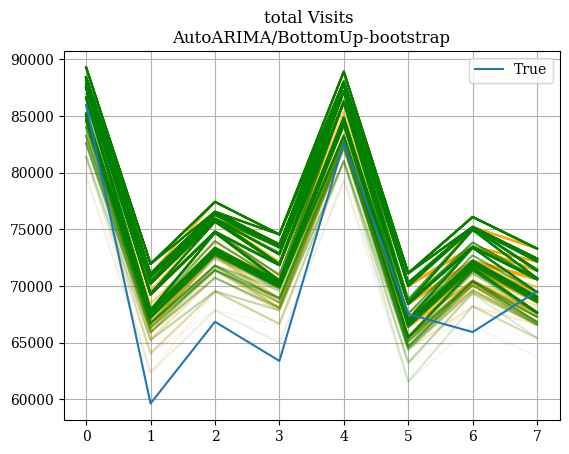

In [ ]:
# Qualitative evaluation, of parsed quantiles
row_idx = 0
seed_idx = 0
col_idxs = model_columns.get_indexer(hrec.level_names['AutoARIMA/BottomUp'])
for i, col in enumerate(col_idxs):
    plt.plot(y_rec[seed_idx, row_idx,:,col], color='orange', alpha=i/100)
for i, col in enumerate(col_idxs):
    plt.plot(y_rec[seed_idx+1, row_idx,:,col], color='green', alpha=i/100)
plt.plot(y_test[row_idx,:], label='True')
plt.title(f'{S_df.index[row_idx]} Visits \n' + \
          f'AutoARIMA/BottomUp-{intervals_method}')

plt.legend()
plt.grid()
plt.show()
plt.close()

In [ ]:
#Y_rec_df
td_levels = hrec.level_names['AutoARIMA/TopDown_method-average_proportions']
Y_rec_df[td_levels]

,AutoARIMA/TopDown_method-average_proportions-lo-98,AutoARIMA/TopDown_method-average_proportions-lo-96,AutoARIMA/TopDown_method-average_proportions-lo-94,AutoARIMA/TopDown_method-average_proportions-lo-92,AutoARIMA/TopDown_method-average_proportions-lo-90,AutoARIMA/TopDown_method-average_proportions-lo-88,AutoARIMA/TopDown_method-average_proportions-lo-86,AutoARIMA/TopDown_method-average_proportions-lo-84,AutoARIMA/TopDown_method-average_proportions-lo-82,AutoARIMA/TopDown_method-average_proportions-lo-80,...,AutoARIMA/TopDown_method-average_proportions-hi-80,AutoARIMA/TopDown_method-average_proportions-hi-82,AutoARIMA/TopDown_method-average_proportions-hi-84,AutoARIMA/TopDown_method-average_proportions-hi-86,AutoARIMA/TopDown_method-average_proportions-hi-88,AutoARIMA/TopDown_method-average_proportions-hi-90,AutoARIMA/TopDown_method-average_proportions-hi-92,AutoARIMA/TopDown_method-average_proportions-hi-94,AutoARIMA/TopDown_method-average_proportions-hi-96,AutoARIMA/TopDown_method-average_proportions-hi-98
0,80750.389920,80750.389920,80750.389920,82299.061781,82299.061781,82299.061781,82600.022716,82600.022716,82600.022716,82763.007090,...,88248.624229,88248.624229,88248.624229,88248.624229,88384.153447,90507.444522,90507.444522,90507.444522,90507.444522,90507.444522
1,61825.843210,61825.843210,61825.843210,61825.843210,61825.843210,61825.843210,63374.515072,63374.515072,63374.515072,63374.515072,...,68196.499405,68196.499405,68286.705654,69324.077520,69324.077520,69437.018534,71582.897812,71582.897812,71582.897812,71582.897812
2,68249.624404,68249.624404,68249.624404,68249.624404,69798.296266,69798.296266,69798.296266,69798.296266,69798.296266,69798.296266,...,74620.280598,74620.280598,74620.280598,74699.211067,75747.858714,75747.858714,75747.858714,75815.623322,78006.679006,78006.679006
3,67456.030661,67456.030661,67456.030661,67456.030661,69004.702523,69004.702523,69004.702523,69004.702523,69004.702523,69305.663457,...,73939.444667,74954.264971,74954.264971,74954.264971,74954.264971,74954.264971,75044.617782,77213.085263,77213.085263,77213.085263
4,80371.819611,80371.819611,80371.819611,80371.819611,80371.819611,81827.571161,81920.491472,81920.491472,81920.491472,81920.491472,...,87870.053920,87870.053920,87870.053920,87870.053920,88005.583138,90128.874213,90128.874213,90128.874213,90128.874213,90128.874213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7115,132.959504,132.959504,132.959504,132.959504,132.959504,135.828870,136.012021,136.012021,136.012021,136.545910,...,147.738932,147.738932,147.738932,152.191189,152.191189,152.191189,152.191189,152.191189,152.191189,152.191189
7116,158.417227,158.417227,158.417227,158.417227,158.417227,161.469743,161.469743,161.469743,161.469743,162.062953,...,170.974136,171.174163,173.196654,173.196654,173.196654,173.419267,177.648912,177.648912,177.648912,177.648912
7117,122.066765,122.066765,125.119281,125.119281,125.119281,125.119281,125.712492,125.712492,125.712492,125.712492,...,134.623675,134.623675,134.801476,136.846192,136.846192,136.846192,137.024283,141.298450,141.298450,141.298450
7118,134.467576,134.467576,134.467576,134.467576,137.520093,137.520093,137.520093,137.520093,138.113303,138.113303,...,145.762241,145.875843,147.202288,149.247004,149.247004,149.247004,149.425094,153.699262,153.699262,153.699262


## 4. Evaluation

In [ ]:
with CodeTimer('Evaluate Models CRPS  ', verbose):
    crps_results = {'Dataset': [dataset] * len(['Overall'] + list(tags.keys())),
                    'Level': ['Overall'] + list(tags.keys()),}

    for model in hrec.level_names.keys():
        crps_results[model] = []
        for level in crps_results['Level']:
            if level=='Overall':
                row_idxs = np.arange(len(S_df))
            else:
                row_idxs = S_df.index.get_indexer(tags[level])
            col_idxs = model_columns.get_indexer(hrec.level_names[model])
            _y = y_test[row_idxs,:]
            _y_rec_seeds = y_rec[:,row_idxs,:,:][:,:,:,col_idxs]

            level_model_crps = []
            for seed_idx in range(y_rec.shape[0]):
                _y_rec = _y_rec_seeds[seed_idx,:,:,:]
                level_model_crps.append(scaled_crps(y=_y, y_hat=_y_rec,
                                                    quantiles=QUANTILES))
            level_model_crps = f'{np.mean(level_model_crps):.4f}±{(1.96 * np.std(level_model_crps)):.4f}'
            crps_results[model].append(level_model_crps)

    crps_results = pd.DataFrame(crps_results)

crps_results

Code block 'Evaluate Models CRPS  ' took:	1.15689 seconds


,Dataset,Level,AutoARIMA/BottomUp,AutoARIMA/TopDown_method-average_proportions,AutoARIMA/TopDown_method-proportion_averages,AutoARIMA/MinTrace_method-ols,AutoARIMA/MinTrace_method-wls_var,AutoARIMA/MinTrace_method-mint_shrink,AutoARIMA/ERM_method-closed_lambda_reg-0.01
0,TourismSmall,Overall,0.0892±0.0013,0.1195±0.0008,0.1197±0.0008,0.0926±0.0010,0.0888±0.0010,0.0893±0.0009,0.1115±0.0016
1,TourismSmall,Country,0.0468±0.0017,0.0479±0.0011,0.0479±0.0011,0.0503±0.0010,0.0506±0.0011,0.0504±0.0011,0.0525±0.0015
2,TourismSmall,Country/Purpose,0.0702±0.0017,0.0928±0.0009,0.0931±0.0009,0.0805±0.0012,0.0727±0.0012,0.0739±0.0011,0.0926±0.0016
3,TourismSmall,Country/Purpose/State,0.1085±0.0011,0.1575±0.0009,0.1579±0.0009,0.1083±0.0011,0.1041±0.0009,0.1045±0.0009,0.1326±0.0019
4,TourismSmall,Country/Purpose/State/CityNonCity,0.1312±0.0012,0.1799±0.0008,0.1800±0.0008,0.1313±0.0013,0.1276±0.0011,0.1282±0.0010,0.1684±0.0030


In [ ]:
with CodeTimer('Evaluate Models MSSE  ', verbose):
    msse_results = {'Dataset': [dataset] * len(['Overall'] + list(tags.keys())),
                    'Level': ['Overall'] + list(tags.keys()),}
    for model in hrec.level_names.keys():
        msse_results[model] = []
        for level in msse_results['Level']:
            if level=='Overall':
                row_idxs = np.arange(len(S_df))
            else:
                row_idxs = S_df.index.get_indexer(tags[level])
            col_idx = model_columns.get_loc(model)
            _y = y_test[row_idxs,:]
            _y_train = y_train[row_idxs,:]
            _y_hat_seeds = y_rec[:,row_idxs,:,:][:,:,:,col_idx]

            level_model_msse = []
            for seed_idx in range(y_rec.shape[0]):
                _y_hat = _y_hat_seeds[seed_idx,:,:]
                level_model_msse.append(msse(y=_y, y_hat=_y_hat, y_train=_y_train))
            #level_model_msse = f'{np.mean(level_model_msse):.4f}±{(1.96 * np.std(level_model_msse)):.4f}'
            level_model_msse = f'{np.mean(level_model_msse):.4f}'
            msse_results[model].append(level_model_msse)

    msse_results = pd.DataFrame(msse_results)

msse_results

Code block 'Evaluate Models MSSE  ' took:	0.73789 seconds


,Dataset,Level,AutoARIMA/BottomUp,AutoARIMA/TopDown_method-average_proportions,AutoARIMA/TopDown_method-proportion_averages,AutoARIMA/MinTrace_method-ols,AutoARIMA/MinTrace_method-wls_var,AutoARIMA/MinTrace_method-mint_shrink,AutoARIMA/ERM_method-closed_lambda_reg-0.01
0,TourismSmall,Overall,0.2502,0.3628,0.3649,0.3034,0.2769,0.2771,0.3941
1,TourismSmall,Country,0.2422,0.3180,0.3180,0.3520,0.3333,0.3290,0.4102
2,TourismSmall,Country/Purpose,0.2065,0.3178,0.3203,0.2559,0.2129,0.2158,0.3345
3,TourismSmall,Country/Purpose/State,0.3288,0.5077,0.5114,0.2947,0.2851,0.2874,0.4554
4,TourismSmall,Country/Purpose/State/CityNonCity,0.3411,0.5047,0.5099,0.3193,0.3051,0.3080,0.4812


In [ ]:
with CodeTimer('Evaluate Models EScore', verbose):
    energy_results = {'Dataset': [dataset] * len(['Overall'] + list(tags.keys())),
                        'Level': ['Overall'] + list(tags.keys()),}
    for model in hrec.sample_names.keys():
        energy_results[model] = []
        for level in energy_results['Level']:
            if level=='Overall':
                row_idxs = np.arange(len(S_df))
            else:
                row_idxs = S_df.index.get_indexer(tags[level])
            col_idxs = model_columns.get_indexer(hrec.sample_names[model])
            _y = y_test[row_idxs,:]
            _y_sample1 = y_rec[0,row_idxs,:,:][:,:,col_idxs[:len(col_idxs)//2]]
            _y_sample2 = y_rec[0,row_idxs,:,:][:,:,col_idxs[len(col_idxs)//2:]]
            level_model_energy = energy_score(y=_y, 
                                              y_sample1=_y_sample1,
                                              y_sample2=_y_sample2,
                                              beta=2)
            energy_results[model].append(level_model_energy)
    energy_results = pd.DataFrame(energy_results)

energy_results

Code block 'Evaluate Models EScore' took:	0.15790 seconds


,Dataset,Level,AutoARIMA/BottomUp,AutoARIMA/TopDown_method-average_proportions,AutoARIMA/TopDown_method-proportion_averages,AutoARIMA/MinTrace_method-ols,AutoARIMA/MinTrace_method-wls_var,AutoARIMA/MinTrace_method-mint_shrink,AutoARIMA/ERM_method-closed_lambda_reg-0.01
0,TourismSmall,Overall,6.708292e+07,7.917294e+07,7.962361e+07,6.918143e+07,6.858725e+07,6.841859e+07,8.184933e+07
1,TourismSmall,Country,3.100350e+07,2.757131e+07,2.757129e+07,3.078769e+07,3.343591e+07,3.271674e+07,3.324654e+07
2,TourismSmall,Country/Purpose,1.919532e+07,2.661024e+07,2.683828e+07,2.222019e+07,1.939814e+07,1.974410e+07,2.663194e+07
3,TourismSmall,Country/Purpose/State,9.499320e+06,1.408613e+07,1.419471e+07,9.025622e+06,8.776764e+06,8.876594e+06,1.209797e+07
4,TourismSmall,Country/Purpose/State/CityNonCity,7.384783e+06,1.090527e+07,1.101934e+07,7.147934e+06,6.976430e+06,7.081158e+06,9.872868e+06


## References

- [Syama Sundar Rangapuram, Lucien D Werner, Konstantinos Benidis, Pedro Mercado, Jan Gasthaus, Tim Januschowski. (2021). 
\"End-to-End Learning of Coherent Probabilistic Forecasts for Hierarchical Time Series\". 
Proceedings of the 38th International Conference on Machine Learning (ICML).](https://proceedings.mlr.press/v139/rangapuram21a.html)
- [Kin G. Olivares, O. Nganba Meetei, Ruijun Ma, Rohan Reddy, Mengfei Cao, Lee Dicker (2022). 
"Probabilistic Hierarchical Forecasting with Deep Poisson Mixtures". 
Submitted to the International Journal Forecasting, Working paper available at arxiv.](https://arxiv.org/pdf/2110.13179.pdf)